<font size="6" font weight = 'bold'> Online Shop Data Analysis Project</font>

In this notebook, we perform an in-depth analysis of the transaction history of an online shop, using a range of data analysis techniques.
The objective is to highlight how use of various data analysis tools can inform and direct potential business policies 
This dataset was aquired on kaggle.com.

List Analysis detail here

Let's first import all the libraries that we are going to us and set our working directory

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math
import datetime
   #...: from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime

os.chdir("C:\\Users\\mar77d\\OneDrive - CSIRO\\Documents\DA_project") #adapt working directory where dataset is located

<font size="5" font color='lightblue' font weight = 'bold'> 1) Data Aquisition and processing</font>

First, we want to load the data and have a quick look out how it is oganised along with some basic analysis

In [2]:
data = pd.read_csv('customer_segmentation.csv',engine = "python") # import data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
counts = data.apply(lambda x: x.count())  #
nulls = data.apply(lambda x: x.isnull().sum())
distincts = data.apply(lambda x: x.unique().shape[0])
#skewness = data.skew()

str = pd.concat([counts, distincts, nulls],axis = 1)
str.columns = ['counts', 'distincts', 'nulls']
display(str)

,counts,distincts,nulls
InvoiceNo,541909,25900,0
StockCode,541909,4070,0
Description,540455,4224,1454
Quantity,541909,722,0
InvoiceDate,541909,23260,0
UnitPrice,541909,1630,0
CustomerID,406829,4373,135080
Country,541909,38,0


These simple functions shows us how the data is structured along with some basic statistics. 
In particular, we notice that the minimum values of Quantity and UnitPrice are negative, suggesting that the dataset includes returns/refunds. In addition, notice that the total number of transcations (541909) differs from the number of description and customerID, as there are missing data for both those Variables.

Let's get rid of the returns/refunds and the missing data and check that the statistics are consistent. Let's also include a variable called 'PriceSale' which represents the Price charged to the customer for the transaction. Note that one transaction relates to one product, and that one customer may have bought different products (several transactions) at the same time.

In [5]:
data = data[np.logical_and.reduce((~(data.CustomerID.isnull()), data.Quantity>0, data.UnitPrice>0))]
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
data['PriceSale'] = data.Quantity*data.UnitPrice
counts = data.apply(lambda x: x.count())
nulls = data.apply(lambda x: x.isnull().sum())
distincts = data.apply(lambda x: x.unique().shape[0])
str = pd.concat([counts, distincts, nulls],axis = 1)
str.columns = ['counts', 'distincts', 'nulls']
display(str)
data.describe()
# Remove negative or return transactions
#cs_df = cs_df[~(cs_df.Quantity<0)]
#cs_df = cs_df[cs_df.UnitPrice>0]

#details = rstr(cs_df)
#display(details.sort_values(by='distincts', ascending=False))
#data.describe()

,counts,distincts,nulls
InvoiceNo,397884,18532,0
StockCode,397884,3665,0
Description,397884,3877,0
Quantity,397884,301,0
InvoiceDate,397884,17282,0
UnitPrice,397884,440,0
CustomerID,397884,4338,0
Country,397884,37,0
PriceSale,397884,2939,0


,Quantity,UnitPrice,CustomerID,PriceSale
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453,22.397000
std,179.331775,22.097877,1713.141560,309.071041
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


The counts of total transactions is consistent throughout. We also notice that the maximum value of Quantity and price can be quite high, let's make sure that these data are not outliers.

In [7]:
data[data.Quantity >=5000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PriceSale
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,3202.92
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,6539.40
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,3096.00
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom,191.16
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,1008.00
433788,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2011-11-02 11:24:00,0.32,16308.0,United Kingdom,960.00
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


In [8]:
data[data.UnitPrice >=1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PriceSale
117054,546328,M,Manual,1,2011-03-11 10:19:00,1687.17,14911.0,EIRE,1687.17
117055,546329,M,Manual,1,2011-03-11 10:22:00,1687.17,14911.0,EIRE,1687.17
144826,548813,M,Manual,1,2011-04-04 13:03:00,2382.92,12744.0,Singapore,2382.92
144828,548813,M,Manual,1,2011-04-04 13:03:00,1252.95,12744.0,Singapore,1252.95
144829,548820,M,Manual,1,2011-04-04 13:04:00,2053.07,12744.0,Singapore,2053.07
145831,548913,M,Manual,1,2011-04-05 09:45:00,1136.30,12669.0,France,1136.30
150615,549468,M,Manual,1,2011-04-08 14:27:00,1867.86,17940.0,United Kingdom,1867.86
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75
200745,554155,M,Manual,1,2011-05-23 11:26:00,1241.98,12757.0,Portugal,1241.98
201553,554301,M,Manual,1,2011-05-23 14:46:00,1241.98,12757.0,Portugal,1241.98


In [10]:
data[data.PriceSale >=5000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PriceSale
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,6539.40
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


It looks like the high number of quantity are associated with relatively cheap items, but constitute the highest total sale price.
The highest unit price are associated with "Manual" product description. We also note that some transactions seem to be linked to postage. Although these transactions seem coherent, let's keep it in mind for the interpretation of our results.

Let's now plot the timeseries of some distinctive variables

<ipython-input-250-1e112bc197cf>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  week_all = data.groupby(pd.Grouper(freq = 'W', key = 'InvoiceDate'))['PriceSale','Quantity'].sum()


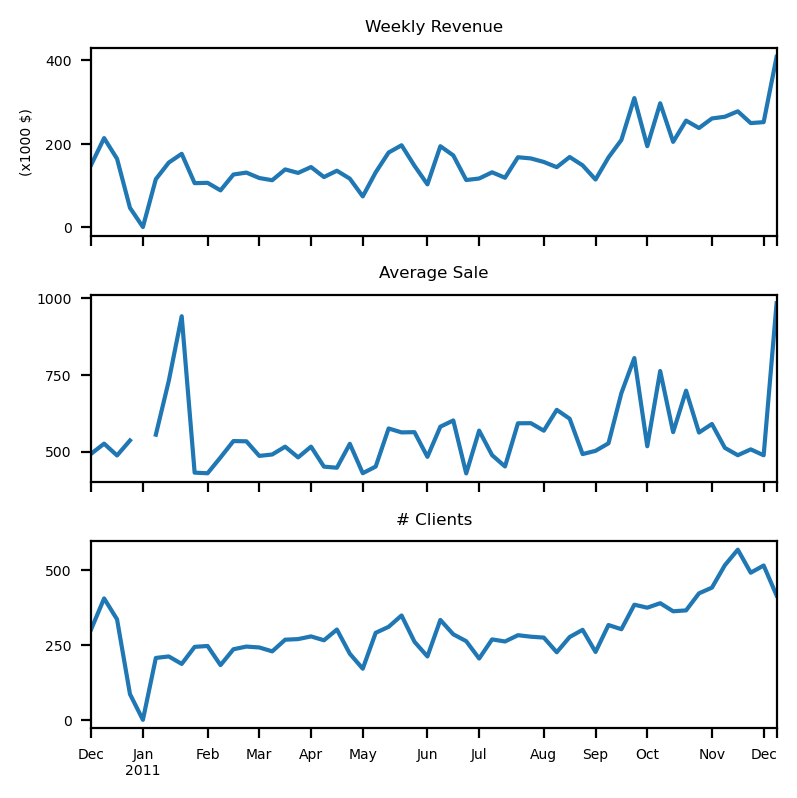

In [250]:
data['Year'] = pd.to_datetime(data.InvoiceDate).dt.year
data['Month'] = pd.to_datetime(data.InvoiceDate).dt.month
data['Week'] = pd.to_datetime(data.InvoiceDate).dt.isocalendar().week

# create weekly averages
week_all = data.groupby(pd.Grouper(freq = 'W', key = 'InvoiceDate'))['PriceSale','Quantity'].sum()
week_all.Quantity = data.groupby(pd.Grouper(freq = 'W', key = 'InvoiceDate'))['CustomerID'].nunique()
week_all.columns = ['Sale','nb_client']
week_all.Sale = week_all.Sale/1000 #in thousands

week_tot_customer = data.groupby(["Year", "Week","CustomerID"])['PriceSale'].sum().groupby(["Year","Week"]).mean() #creates dataframe of mean total sale per customer per week
week_tot_customer = week_tot_customer.reset_index()
week_tot_customer.set_index(pd.to_datetime(week_tot_customer.Year*1000+week_tot_customer.Week*10+0, format = '%Y%W%w'),inplace=True)
week_all['AvgSale']=week_tot_customer.PriceSale

#plot
fig, axe = plt.subplots(3,1,figsize=(4,4), dpi=200)
week_all['Sale'].plot(ax = axe[0], xlabel='', title='Weekly Revenue', ylabel='(x1000 $)', fontsize = 5)
axe[0].set_xticklabels('')
week_all['AvgSale'].plot(ax=axe[1], xlabel='', title='Average Sale', fontsize = 5)
#week_all['nb_client'].plot(ax = axe[1], xlabel='', title='# Clients', fontsize = 5)
axe[1].set_xticklabels('')
week_all['nb_client'].plot(ax = axe[2], xlabel='', title='# Clients', fontsize = 5)
for i in axe:
    i.title.set_size(6)
    i.yaxis.label.set_size(5)
    i.minorticks_off()
fig.tight_layout(pad =0.75)

These timeseries plot show that weekly revenues have been increasing during 2011. The increase was mostly explaind by a gradual increase in the number of weekly clients/sale rather than a change in the average amount paid by customers. We also note that the peaks in average sale in Jan and Dec 2011 are associated with the sales of a large quantity of cheap items mentionned above.

Let's now look at differences amongst countries.

<ipython-input-274-fa5d66b2959b>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  month_cty = data.groupby(['Year', 'Month','Country'])['PriceSale','Quantity'].sum()


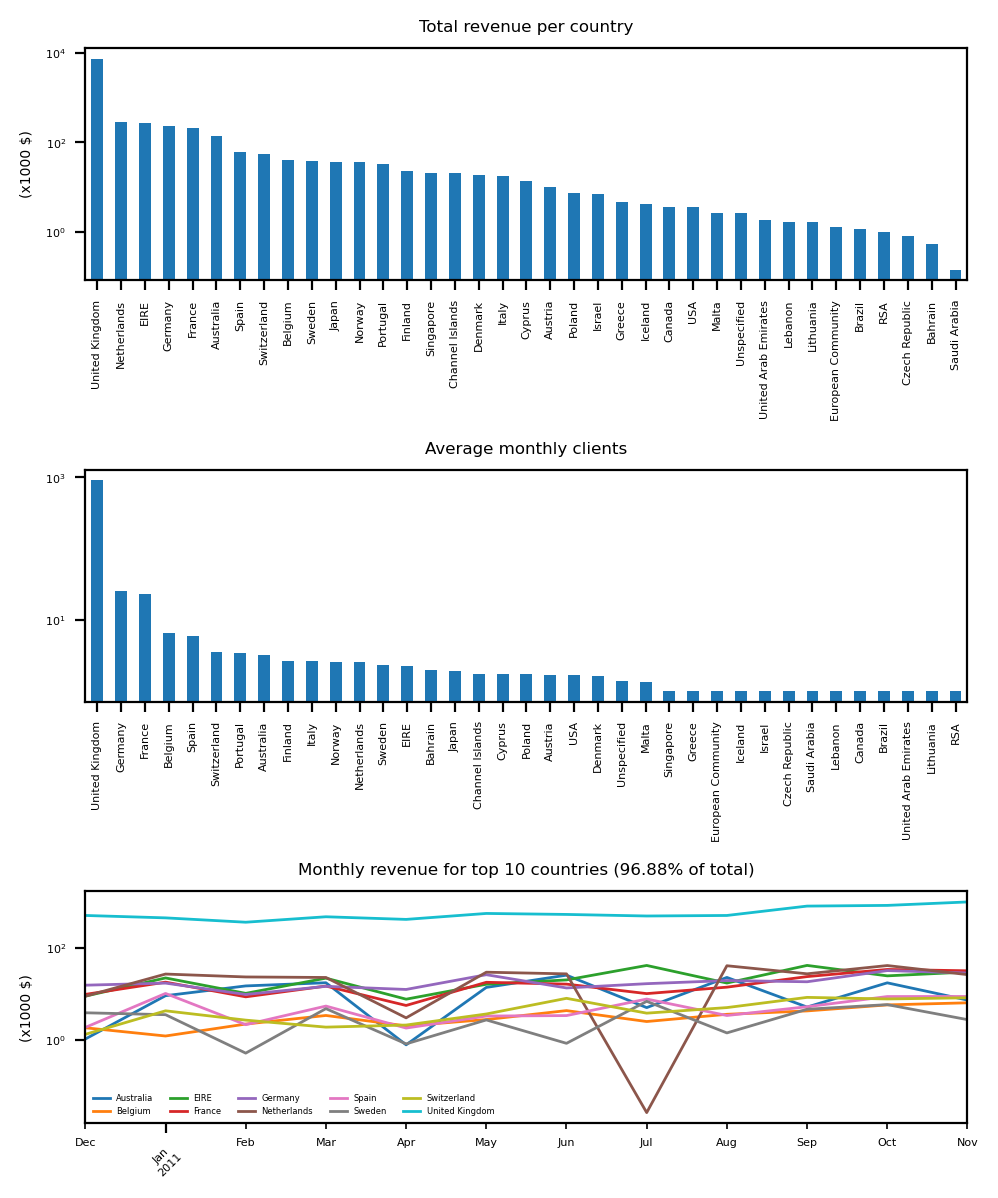

In [274]:
Sale_country = data.groupby(["Country"])['PriceSale'].sum().sort_values(ascending = False)/1000# all countries
top10_sc = data.groupby(["Country"])['PriceSale'].sum().sort_values(ascending = False)[:10]/1000 # top 10 countries
PercentSales =  np.round(100*top10_sc.sum()/Sale_country.sum(), 2)# get the proportion of sales of top 10 countries

month_cty = data.groupby(['Year', 'Month','Country'])['PriceSale','Quantity'].sum()
month_cty['nb_client'] = data.groupby(["Year", "Month","Country"])['CustomerID'].nunique()
month_cty.PriceSale = month_cty.PriceSale/1000
month_cty['avg_sale'] = data.groupby(["Year", "Month","CustomerID","Country"])['PriceSale'].sum().groupby(["Year","Month","Country"]).mean() 
month_cty = month_cty[np.in1d(month_cty.index.get_level_values(2),top10_sc.reset_index()['Country'].to_numpy())]
month_cty = month_cty.reset_index()
month_cty.set_index([pd.to_datetime(month_cty.Year*10000+month_cty.Month*100+1, format = '%Y%m%d'),'Country'],inplace=True)

#plot
fig, axe = plt.subplots(3,1,figsize=(5,6), dpi=200)
Sale_country.plot.bar(ax = axe[0], xlabel='', title='Total revenue per country', ylabel='(x1000 $)', fontsize = 4)
data.groupby(["Year", "Month","Country"])['CustomerID'].nunique().groupby("Country").mean().sort_values(ascending = False).plot.bar(ax = axe[1], xlabel='', title='Average monthly clients', ylabel='', fontsize = 4)

month_cty["PriceSale"].unstack(level=1).plot(ax = axe[2], title='Monthly revenue for top 10 countries ({:3.2f}% of total)'.format(PercentSales), fontsize=4, ylabel='(x1000 $)',linewidth=1)
plt.legend(fontsize=3,ncol=5,frameon=False)
axe[2].set_xlim([datetime(2010,12,1),datetime(2011,11,1)])
for i in axe:
    i.title.set_size(6)
    i.yaxis.label.set_size(5)
    i.set_yscale('log')
    i.minorticks_on
fig.tight_layout(pad =0.75)


The breakdown of total revenue shows that most of it comes from the United Kingdom. In fact, sales from the United Kingdom are two orders of magnitude above other countries. The number of clients is also significantly higher in the United Kingdom, averging around 1000 per month, whereas oher countries have no more than 15 clients per month.

The evolution of monthly revenues per countries show that the increasing tendency is common to the top 10 countries. Note that in July 2011, there were no sales made in the Netherlands (second highest total revenue), but other countries seemed unaffected. 

A large majority of the company's revenue and clients are located in the Unitied Kingdom. The incentive to adopt business policies targetting people in other countries is therefore strong.

<font size="5" font color='lightblue' font weight = 'bold'> 2) Cluster Analysis</font>

The use of cluster blahbliblou